In [ ]:
# !pip install pyyaml==5.1
# import torch, torchvision
# print(torch.__version__, torch.cuda.is_available())
# !gcc --version

In [ ]:
# import torch
# assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode

from sklearn.decomposition import PCA
%matplotlib inline

/data/xiaodan8/anaconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train on a custom dataset

## Prepare the dataset

In [2]:
from detectron2.structures import BoxMode

DatasetCatalog.clear()

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "pig_coco.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    imgs_names = imgs_anns["images"]
    annos = imgs_anns["annotations"]
    
    dataset_dicts = []
    for idx, imgfile in enumerate(imgs_names):
        record = {}
        
        record["file_name"] = imgfile["file_name"]
        record["image_id"] = imgfile["id"]
        record["height"] = imgfile["height"]
        record["width"] = imgfile["width"]
      
        objs = []
        for anno in annos:
            if anno["image_id"] == imgfile["id"]:
                obj = {
                    "bbox": anno["bbox"],
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": anno["segmentation"],
                    "category_id": 0,
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "test"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_balloon_dicts("/data/xiaodan8/research/Pig_3D_beta/pig_segment/pig_life/" + d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=["pig"])
balloon_metadata = MetadataCatalog.get("my_dataset_train")

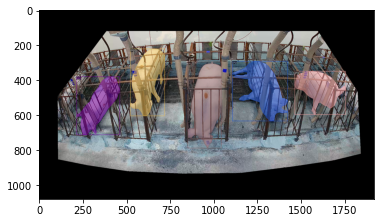

In [3]:
dataset_dicts = get_balloon_dicts("/data/xiaodan8/research/Pig_3D_beta/pig_segment/pig_life/test")
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

## Train

In [4]:
model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

'/data/xiaodan8/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'

In [5]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

In [6]:
cfg.OUTPUT_DIR

'./output'

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/30 06:26:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:04, 44.1MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[04/30 06:26:46 d2.engine.train_loop]: Starting training from iteration 0


/data/xiaodan8/anaconda3/envs/detectron2/lib/python3.8/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/data/xiaodan8/anaconda3/envs/detectron2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/30 06:26:51 d2.utils.events]:  eta: 0:01:12  iter: 19  total_loss: 2.341  loss_cls: 0.6503  loss_box_reg: 0.9651  loss_mask: 0.692  loss_rpn_cls: 0.01666  loss_rpn_loc: 0.02774  time: 0.2566  data_time: 0.0304  lr: 1.6068e-05  max_mem: 2438M
[04/30 06:26:57 d2.utils.events]:  eta: 0:01:08  iter: 39  total_loss: 2.267  loss_cls: 0.5877  loss_box_reg: 0.9741  loss_mask: 0.6805  loss_rpn_cls: 0.01501  loss_rpn_loc: 0.02345  time: 0.2622  data_time: 0.0257  lr: 3.2718e-05  max_mem: 2438M
[04/30 06:27:02 d2.utils.events]:  eta: 0:01:03  iter: 59  total_loss: 2.165  loss_cls: 0.517  loss_box_reg: 0.9489  loss_mask: 0.663  loss_rpn_cls: 0.01294  loss_rpn_loc: 0.02393  time: 0.2632  data_time: 0.0134  lr: 4.9367e-05  max_mem: 2438M
[04/30 06:27:07 d2.utils.events]:  eta: 0:00:57  iter: 79  total_loss: 2.033  loss_cls: 0.4522  loss_box_reg: 0.9206  loss_mask: 0.6296  loss_rpn_cls: 0.007032  loss_rpn_loc: 0.02216  time: 0.2634  data_time: 0.0167  lr: 6.6017e-05  max_mem: 2438M
[04/30 06:27:1

## Testing

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

True

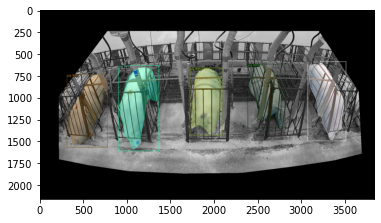

In [11]:
from detectron2.utils.visualizer import ColorMode


im = cv2.imread('./pig_life/test/1050s1132a1110s3003-5s5001-1(525).png')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_img = out.get_image()[:, :, ::-1]
out_img = cv2.resize(out_img, dsize=(3840, 2160))
plt.imshow(out_img)
cv2.imwrite('./output_img/foo.png', out.get_image()[:, :, ::-1])

True

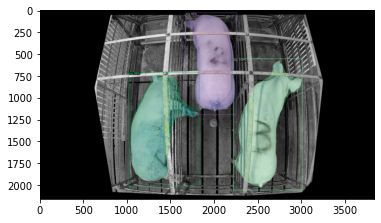

In [12]:
from detectron2.utils.visualizer import ColorMode


im = cv2.imread('./pig_life/test/1040s1132s3005-3s5001-1(30).png')
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=balloon_metadata, 
               scale=0.5, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_img = out.get_image()[:, :, ::-1]
out_img = cv2.resize(out_img, dsize=(3840, 2160))
plt.imshow(out_img)
cv2.imwrite('./output_img/foo2.png', out.get_image()[:, :, ::-1])


## Load model and inference on your image

In [ ]:
### load model ###
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)